In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [3]:
varinfo.clear()

In [4]:
# signaltrees = ObjIter([ Tree(f) for f in fc.eightb.preselection.signal_list ])
signaltrees = ObjIter([ Tree(fc.eightb.preselection.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])

In [14]:
for tree in signaltrees: tree.color=None

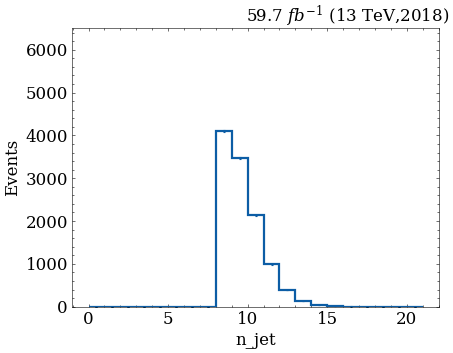

In [46]:
study.quick(
    signaltrees,
    varlist=['n_jet']
)

In [48]:
top8_btag = CollectionFilter('jet', filter=lambda t:ak.argsort(ak.argsort(t.jet_btag,axis=-1,ascending=False))<8)
signaltrees =  signaltrees.apply(top8_btag.filter)

In [153]:
signaltrees.apply(lambda t : build_all_dijets(t) )

[None]

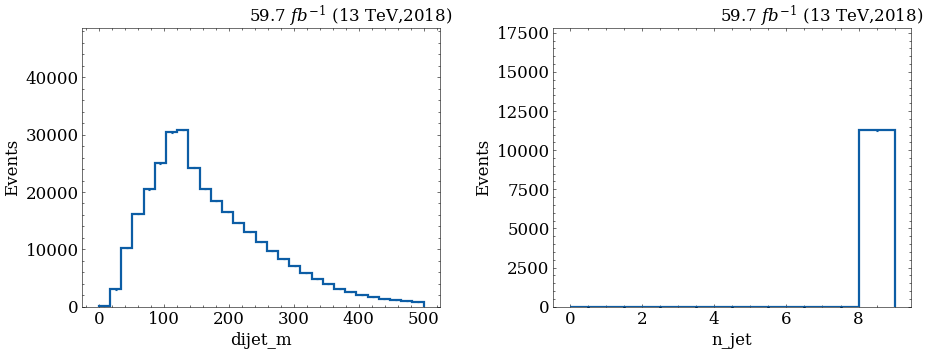

In [154]:
study.quick(
    signaltrees,
    varlist=['dijet_m','n_jet'],
    binlist=[np.linspace(0,500,30)] 
)

In [155]:
dijets = get_collection(signaltrees[0], 'dijet', False)

In [156]:
m_avg = ak.mean(dijets[dijets.signalId>-1].m)

In [157]:
m_diff = np.abs(dijets.m - m_avg)

(<Figure size 384x360 with 1 Axes>, <AxesSubplot:ylabel='Events'>)

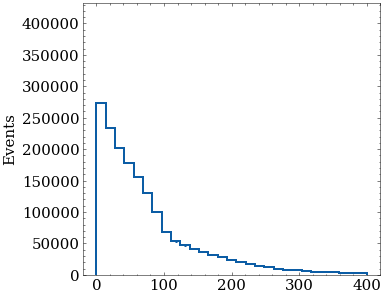

In [158]:
hist_multi([m_diff], bins=np.linspace(0,400,30))

In [159]:
m_rank = ak.argsort(ak.argsort(m_diff, axis=-1))

In [160]:
m_diff[0], m_rank[0]

(<Array [205, 105, 78.9, ... 9.69, 90.2, 30.9] type='28 * float32'>,
 <Array [27, 25, 22, 7, 23, ... 14, 6, 24, 12] type='28 * int64'>)

In [161]:
dijet_sig = dijets.signalId>-1
dijet_bkg = dijets.signalId==-1
R = np.arange(28)
eff = ak.Array([ ak.sum(dijet_sig[m_rank<r])/ak.sum(dijet_sig) for r in R ])
pur = ak.Array([ ak.sum(dijet_sig[m_rank<r])/(ak.sum(m_rank<r)) for r in R ])

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:ylabel='Events'>)

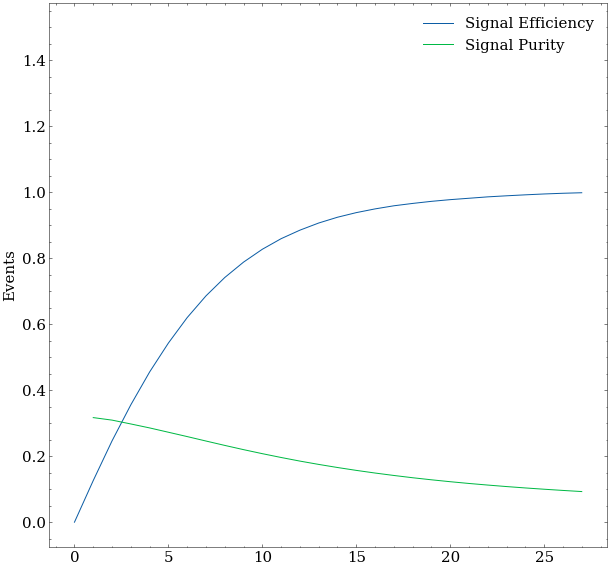

In [162]:
figax=plt.subplots(figsize=(10,10))
graph_arrays([R,R],[eff,pur],figax=figax,g_label=['Signal Efficiency','Signal Purity'],g_label_stat=None,legend=True)

In [163]:
quadH_index = eightb.get_quadH_pairings()

In [164]:
quadH_m = signaltrees[0].dijet_m[:,quadH_index]
quadH_signalId = signaltrees[0].dijet_signalId[:,quadH_index]

In [165]:
quadH_m = ak.sort(quadH_m,axis=-1)

In [173]:
def var_asym(v1,v2): return np.abs(v1-v2)
# def var_asym(v1,v2): return np.abs(v1-v2)/(v1+v2)


In [174]:
quadH_asym = var_asym(quadH_m[:,:,3],quadH_m[:,:,0])

In [175]:
min_asym = ak.argmin(quadH_asym,axis=-1)

In [176]:
min_asym

<Array [47, 104, 89, 99, ... 103, 39, 44, 37] type='62904 * ?int64'>

In [177]:
n_quadH = ak.sum(quadH_signalId>-1,axis=-1)

In [178]:
quadH_mask = ak.local_index(quadH_asym,axis=-1) == min_asym
nfound_minmass = n_quadH[quadH_mask][:,0]

(<Figure size 384x360 with 1 Axes>, <AxesSubplot:ylabel='PDF'>)

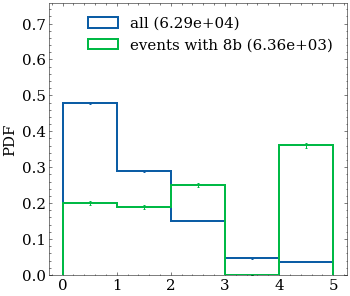

In [181]:
sig_mask = tree.nfound_select==8
hist_multi([tree.nfound_paired_h,tree.nfound_paired_h[sig_mask]], density=True, h_label=['all','events with 8b'], legend=True)

In [126]:
tree = signaltrees[0]

In [130]:
[ field for field in tree.fields if 'nfound' in field ]

['nfound_all',
 'nfound_all_h',
 'nfound_presel',
 'nfound_presel_h',
 'nfound_select',
 'nfound_select_h',
 'nfound_paired_h']

In [131]:
tree.nfound_paired_h == n_

<Array [1, 0, 0, 0, 0, 0, ... 2, 4, 0, 1, 0, 3] type='62904 * int32'>